In [1]:
using ApproxFun, Poltergeist, Plots

#### The map $f_n$

In [2]:
const Uc = 0.97; # a number that turns up a lot

struct InvMap <: Function # struct encoding an inverse branch of the map
K::Float64      # value of coupling parameter
i::Int          # branch index, ∈ {±1}
end
(v::InvMap)(q) = (q + v.i + v.K*(1-sqrt(1 - Uc*(1-q^2))))/2 # an InvMap can be called like a function

f_map(K) = MarkovMap([InvMap(K,-1),InvMap(K,1)], # inverse branches
    [-1.0..0.0,0.0..1.0],                        # domains of inverse branches
    dir=Reverse                                  # defining via inverse
    ) # initialises full-branch map for given K

f_map (generic function with 1 method)

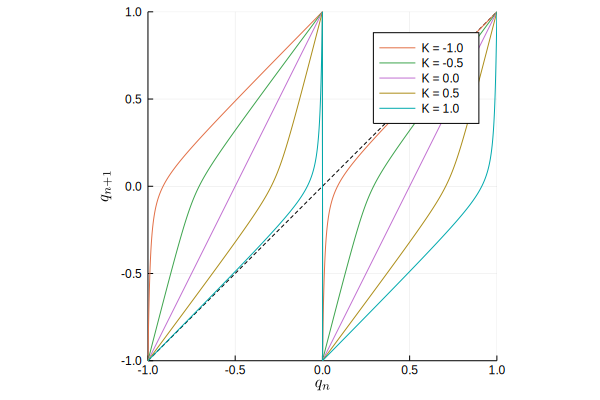

In [3]:
lsp = -1:0.001:1
plot(lsp,lsp,color="black",style=:dash,label="")
for K = (-1:0.5:1)
    plot!(lsp,f_map(K).(lsp),label="K = $K")
end
plot!(xaxis=("\$q_n\$",(-1,1)),yaxis=("\$q_{n+1}\$",(-1,1)),aspect_ratio=:equal)


#### The coupled system

In [4]:
const pbasis = Chebyshev(-1.0..1.0) # polynomial basis
const ϕ = Fun(q->-23/30 + 7q^2/2 - 2q^4,pbasis) # Chebyshev approximation of the coupling function ϕ
get_Φ(μ_n) = sum(ϕ*μ_n)

# Outputs μ_{n+1} and Φ_{n+1} given inputs μ_n, ε and driving d, which is by default Φ_{n}
function F(μ_n, ε, d = get_Φ(μ_n))
    f_n = f_map(tanh(d*ε-2))
    μ_n1 = transfer(f_n,μ_n)
    μ_n1, get_Φ(μ_n1)
end

F (generic function with 2 methods)

#### Dynamics

In [5]:
μ = 1 + 0.3Fun(pbasis,rand(6)); # randomised initial distribution of q^(j)
μ /= sum(μ) # to make a probability measure 
ε = 30
for i = 1:20
    μ, Φ = F(μ,ε)
    println(Φ)
end

-0.016868760481133678
0.04904521223887643
0.07554024986924293
0.02227173099549934
0.055472303875795215
0.03598720897963178
0.07187460223747386
9.626779825364085e-5
0.06195627708332265
0.016979332226903357
0.08027213214900042
-0.03341453711420589
0.049374122875738835
0.04172548603617275
0.06713859156759416
0.014924794659665452
0.06907820823473912
0.001394423714142723
0.07043535576545798
-0.00830367404151193


#### Code speed

In [6]:
@time for i = 1:1000
    global μ # need inside @time wrapper
    μ, _ = F(μ,ε)
end

  0.772740 seconds (6.14 M allocations: 250.516 MiB, 8.28% gc time)


#### Attractor

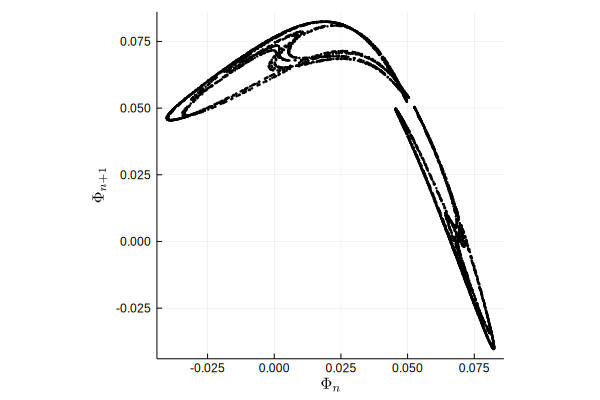

In [7]:
N = 5000
Φh = Array{Float64}(undef,N)

for i = 1:1000 #spinup
    μ, Φ = F(μ,ε)
end

for i = 1:N
    μ, Φh[i] = F(μ,ε)
end
scatter(Φh[1:end-1],Φh[2:end],markersize=1.5,markerstrokewidth=0,markercolor=:black,label="",
    xlabel="\$\\Phi_n\$", ylabel="\$\\Phi_{n+1}\$", aspect_ratio=:equal)